In [1]:
library(showtext)
showtext_auto()
library(coda)
library("gplots")

Loading required package: sysfonts
Loading required package: showtextdb
Warning message:
“package ‘coda’ was built under R version 3.6.3”
Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



# Markov Chain Monte Carlo (MCMC)

MCMC is a powerful, generic method, for approximately generating samples from any Posterior distribution.

In order to obtain these samples is necessary to have a prior distribution $P(\theta)$ and a Likelihood function $P(D|\theta)$. Both quantities should be calculated up to a multiplicative constant, it means that there is no need to calculate the evidence.

- The "Monte Carlo" part of the name is due to the generation of random samples from the distribution.

## The islands example

 The archipielago of Tierra del Fuego is composed by 10 little islands, each of this islands is numerated according to it's population. The archipielago has only one doctor and she should spend an ammount of time proportional to the island population in each of them.
 
 - at the beginning of each week , the doctor can:
     - stay on the current island
     - move to an ADJACENT island
     

At the beggining of each week the doctor:
   - flips a coin to decide to which island to go (Head->East or Tail->West)
   - if the proposed island has a larger population than the actual island she moves
   - if the proposed island has a smaller population, the probability of is proportional to the ratio of populations (it is always smaller than one) 
    
    $$P_{move}= MIN\left[\frac{P_{proposed}}{P_{current}},1\right]$$
    

In [2]:
p_move <- function(p_prop,p_curr){min(p_prop/p_curr,1)}

coin_flip <- function(){sample(c(0,1), replace=TRUE,size=1)}

new_position <- function(c,pos){
    if(c<0.5){if(pos==1){new_p<-10
                       }else {new_p <- pos-1}
        
    }else{if(pos==10){new_p<-1
                       }else {new_p <- pos+1}}
    return(new_p)
}

In [3]:
set.seed(123)
n <- 1.e5
weeks <- c(1:n)

position <- c(7)

for (i in weeks) {
    coin <- coin_flip()
    n_p  <- new_position(coin,position[i])
    p_m  <- p_move(n_p,position[i])
    
    #position <-c(position,n_p)
    if ( p_m > runif(1, 0, 1)){
         position <-c(position,n_p)   
    }else{position <-c(position,position[i])}
    
}
position <- position[-n+1]

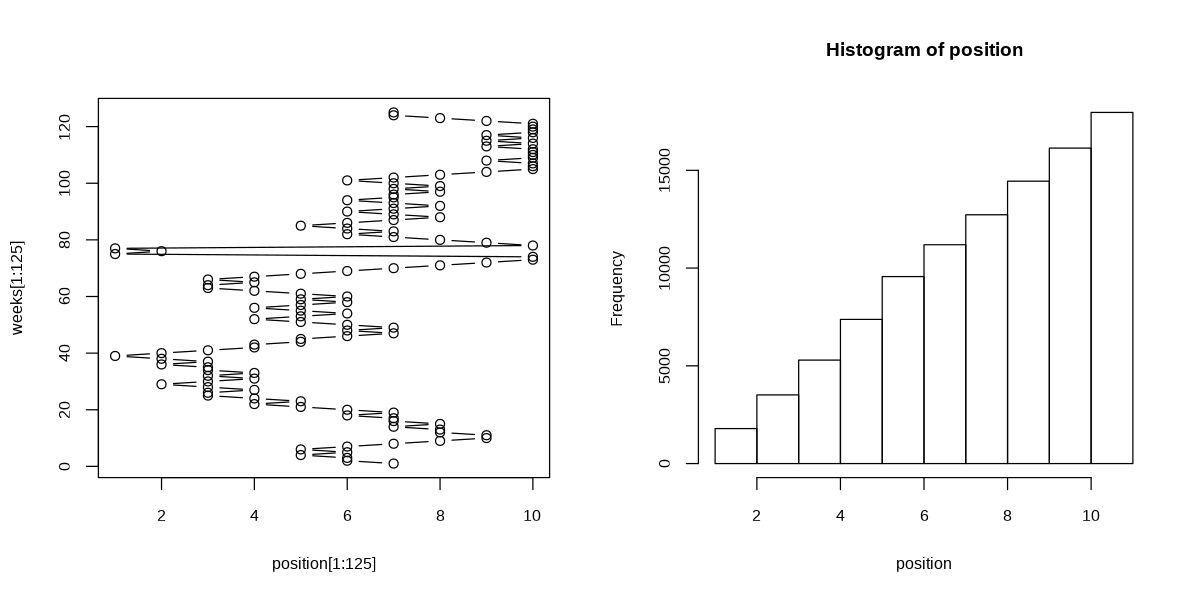

In [4]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow=c(1,2))
plot(position[1:125],weeks[1:125],type="b")
hist(position,breaks=c(1,2,3,4,5,6,7,8,9,10,11),right=FALSE)

## MCMC

Let's assume we want to sample from a complex distribution $f(\theta)$, we have already seen that the brute force methods are not efficients. We would prefer to take samples in the region where $f(\theta)$ is high, but still keeping a sample which represents $f$.

The principle behind MCMC is to set up a random walk over the parameter space which explores the regions of high probability density of $f(\theta)$. This random walk is done through a Markov Chain: i.e. a random process in which the probability of evolving from a state $\theta_t$ -> $\theta_{t+1}$ is defined by a transition probability $Q(\theta_{t+1}|\theta_t)$ which does not depend on the previous states. 


The algorithm:
    
   0) Initialize the chain at some value
    
   1) draw a random sample from the distribution $Q(s|\theta)$ 
   
   This is often a multivariate Gaussian where $\theta_t$ is the mean and the covariance matrix specifies the typical size of steps in the chain in each dimension of the parameter $\theta$
       
   2) Decide whether to accept or not the new candidate sample on the basis of the metropolis ratio
   
   $$ \rho =\frac{f(s)}{f(\theta_t)}\frac{Q(\theta_t|s)}{Q(s|\theta_t)}$$
   
   - if $\rho \ge 1$ the new candidate is accepted and $\theta_{t+1}=s$
   
   - if $\rho \le 1$  we only accept it with probability $\rho$:
   
       - draw $u \sim U(0,1)$ and set $\theta_{t+1}=s$ only if $u\leq\rho$
       
if $s$ is not accepted, we set $\theta_{t+1}=\theta_t$, i.e. the existing sample in the chain is repeated
    


### Sampling from the Cauchy distribution

$$\text{Cauchy}(x|x_0,\gamma)= \frac{1}{\pi  \gamma}\frac{1}{1+((x-x_0)/\gamma)^2}$$

where $\gamma$ and $x_0$ are called scale and location parameters, let consider $(x_0=10,\gamma=2)$

In [5]:
cauchy = function(x,location=10,scale=2){((pi * scale) * (1+((x-location)/scale)**2))**-1}
fun = function(x){cauchy(x,-10,2) + 4 * cauchy(x,10,4)}
x <- seq(-50,50,0.2)

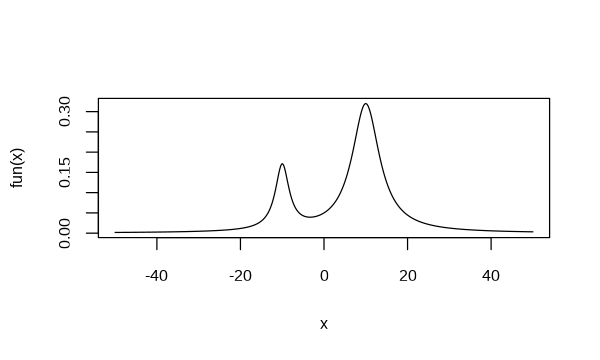

In [6]:
options(repr.plot.width = 5, repr.plot.height = 3)
plot(x,fun(x),type="l")

In [7]:
metropolis.1dim <- function(func, theta.init, n.sample,sigma){
    theta.cur   <- theta.init
    func.cur    <- func(theta.cur)
    func.samp   <- matrix(data=NA, nrow=n.sample, ncol=2+1)
    n.accept    <- 0
    rate.accept <- 0.0
    
    for (n in 1:n.sample){
        
        theta.prop <- rnorm(n=1, mean = theta.cur, sigma)
        func.prop <- func(theta.prop)
        logMR <- func.prop -func.cur   #Log 10 of the metropolis ratio
        
        if (logMR >= 0 || logMR > log10(runif(1))){
            theta.cur <- theta.prop
            func.cur  <- func.prop
            n.accept  <- n.accept + 1
        }
        func.samp[n,1] <- func.cur
        func.samp[n,2] <- theta.cur
    }
    return(func.samp)
}

In [8]:
#Interface for the metropolis function, get the log10 of the test function
fun.metropolis <- function(theta){return(log10(fun(theta)))}

In [9]:
#Running parameters
theta.init <- -5
sample.sig <- 10
n.sample   <- 1.e5
demo       <- TRUE

set.seed(20190513)
chain <- metropolis.1dim(func=fun.metropolis,
                         theta.init = theta.init,
                        n.sample = n.sample,
                        sigma = sample.sig**2)

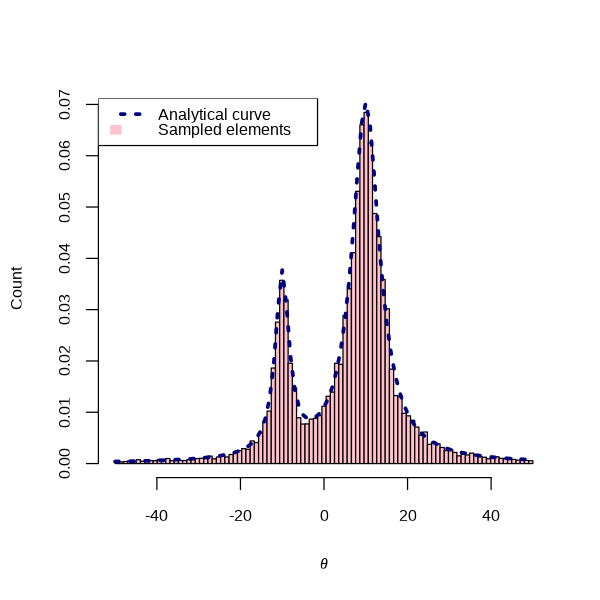

In [10]:
options(repr.plot.width = 5, repr.plot.height = 5)
sa <- which(chain[,2]>= min(x) & chain[,2]<= max(x))
hist(chain[sa,2],breaks=seq(from=-50, to=50,length.out=100),
     freq=FALSE,
     col="pink",
     ylab="Count",
     xlab=expression(theta),
     main='')

curve(fun(x)*0.22,
      col="navy", lt=3, lw=3, add=TRUE,)

legend("topleft", legend = c("Analytical curve", "Sampled elements"),
       lt=3, lw=3,
       density=c(0,100),
       col = c("navy", NA),
       fill=c("navy", "pink"),
       border=c(NA,"pink"))

Now we use the coda R package to perform an analysis of our MCMC chain

In [11]:
library(coda)
#Running parameters
theta.init <- -5
n.sample   <- 1.e5
demo       <- TRUE

set.seed(20190513)

c.chain1 <- as.mcmc(metropolis.1dim(func=fun.metropolis, theta.init = theta.init, n.sample = n.sample,
                                    sigma = 0.5**2)[,2])
c.chain2 <- as.mcmc(metropolis.1dim(func=fun.metropolis, theta.init = theta.init, n.sample = n.sample,
                                    sigma = 1**2)[,2])
c.chain3 <- as.mcmc(metropolis.1dim(func=fun.metropolis, theta.init = theta.init, n.sample = n.sample,
                                    sigma = 5**2)[,2])
c.chain4 <- as.mcmc(metropolis.1dim(func=fun.metropolis, theta.init = theta.init, n.sample = n.sample,
                                    sigma = 10**2)[,2])



In [12]:
my.lags =seq(0,500,10)
y1 <- autocorr(c.chain1, lags=my.lags)
y2 <- autocorr(c.chain2, lags=my.lags)
y3 <- autocorr(c.chain3, lags=my.lags)
y4 <- autocorr(c.chain4, lags=my.lags)

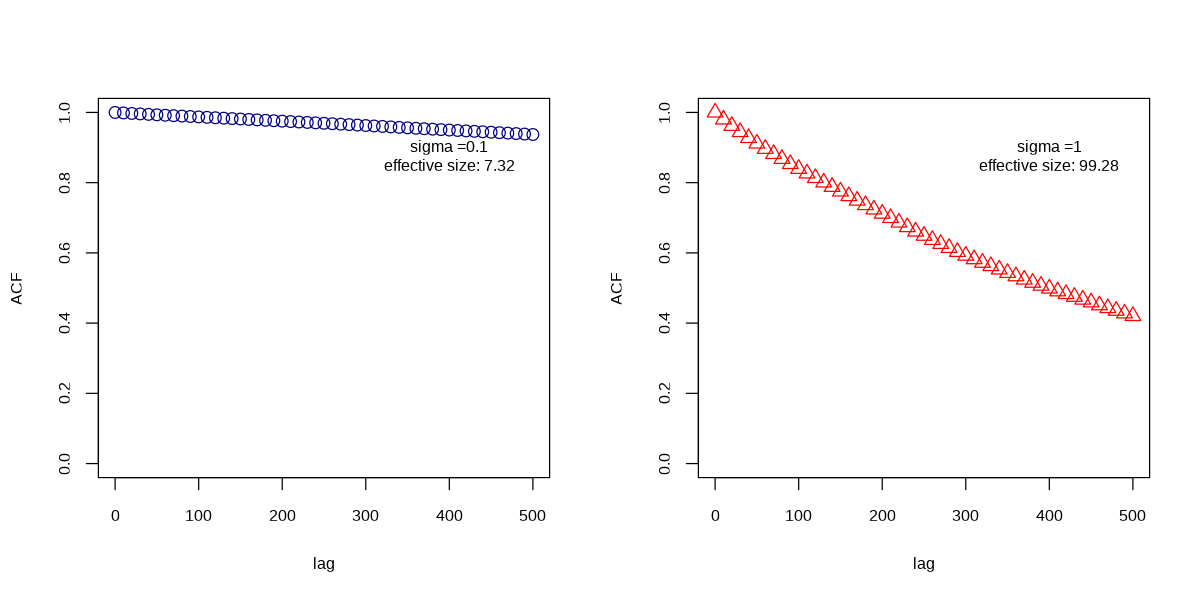

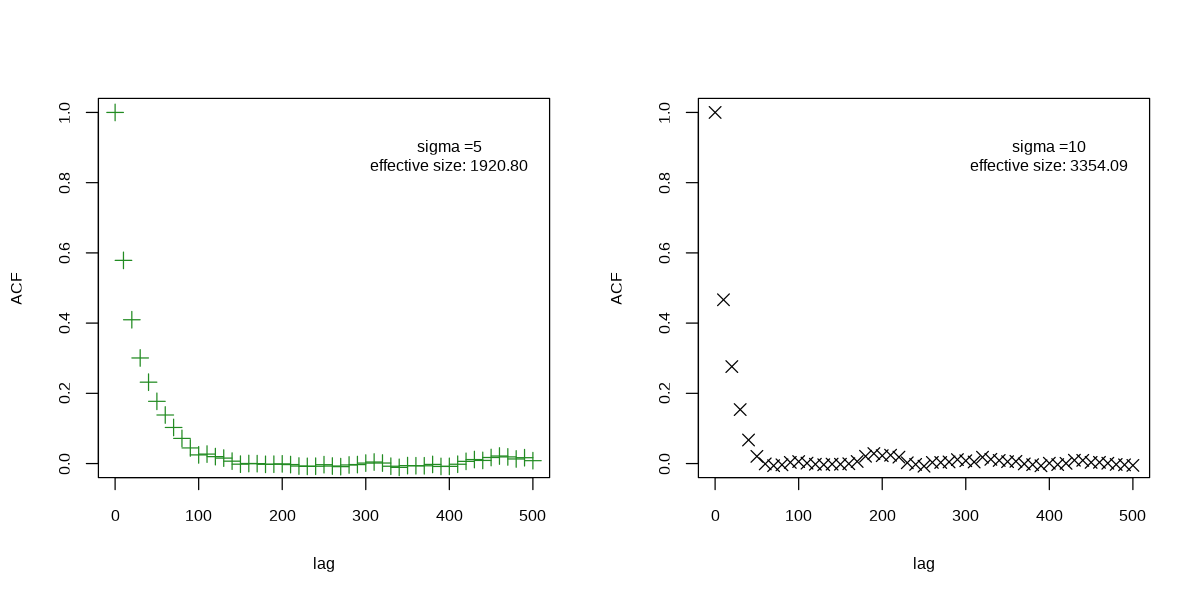

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow=c(1,2),mfcol=c(1,2))

plot(my.lags, y1, ylim=c(0,1),
    pch=1, col='navy',
    xlab='lag',ylab='ACF',cex=1.3)
text(400,0.9, paste('sigma =0.1'))
text(400,0.85, sprintf ("effective size: %.2f", effectiveSize(c.chain1)))

plot(my.lags, y2, ylim=c(0,1),
    pch=2, col='red',
    xlab='lag',ylab='ACF',cex=1.3)
text(400,0.9, paste('sigma =1'))
text(400,0.85, sprintf ("effective size: %.2f", effectiveSize(c.chain2)))

plot(my.lags, y3, ylim=c(0,1),
    pch=3, col='forestgreen',
    xlab='lag',ylab='ACF',cex=1.3)
text(400,0.9, paste('sigma =5'))
text(400,0.85, sprintf ("effective size: %.2f", effectiveSize(c.chain3)))

plot(my.lags, y4, ylim=c(0,1),
    pch=4, col='black',
    xlab='lag',ylab='ACF',cex=1.3)
text(400,0.9, paste('sigma =10'))
text(400,0.85, sprintf ("effective size: %.2f", effectiveSize(c.chain4)))

### Parameter estimation with MCMC

In general no parameter is known in advance and we want to infer the posterior from the data

$$p(\theta|D) \propto p(D|\theta) x P(\theta)$$

given the data, D, the procedure to compute the posterior is as follows:

    - define the prior for the parameters
    - define the covariance matrix of the proposal distribution
    - define the starting point of the MCMC
    define the number of burn-in and sampling interaction
    
Once the MCMC data have been collected, perform the following analysis:

    - make the chain thinner
    - plot the chains and the one one-dimensional marginal posterior pdf over the parameters
    - plot the two dimensional posterior distribution of all three parameters, simply by plotting the samples, and look for correlations between the parameters
    - calculate the maximum a posteriori values of the model parameters from the MCMC chains.
    - calculate the predictive posterior distribution over $y$ at new data points.

- We have a 2-dim set of points $[x_j;y_j]$

- the model M predicts:
    - $y=f(x) + \epsilon$
    - where $f(x) = b_0 + b_1 \,x$
    
- $f(x)$ is a generative model

- The residuals $ \epsilon= y-f(x)$ are modeled as a zero-mean Gaussian function with standard deviation $\sigma$ NOISE MODEL 

- assuming ${x_j}$ are noise-free, and $\theta = (b_0,b_1,\sigma)$, the likelihood is

$$P(y_j|x_j,\theta,M)=\frac{1}{\sigma\sqrt{2\pi}} \text{exp}\left[-\frac{(y_j-f(x_j;b_0,b_1))^2}{2\sigma~ 2}\right]$$

- we try to infer $\sigma$ from the data

- although the $x_j$ values are suplied with the data, they are assumed to be fixed and not described by a measurement model. Therefore $D={y_j}$

- assuming data points are independent, the log-likelihood for all the data points is:

$$\text{ln}P({y_j}|{x_j},\theta,M)= \sum^N_{j=1} P(y_j|x_j,\theta,M)$$

Parameter priors:

- For the intercept, $b_0$:
    - $P(b_0)=N(\mu,\sigma)$ A Gaussian distribution.
    
- For the gradient, $b_1$:
    - we can refer it to an angle $b_1 =\text{tan}\alpha$. Since we have no prior knowledge about the slope, we should use a uniform distribution  $P(\alpha) = 1/2\pi$
    
- standard deviation, $\sigma$:
    - in the absence of any other information, a scale parameter such as the standard deviation of a Gaussian should be assigned a Jeffreys prior.
    - $P(\sigma) \propto \text{log}\sigma$. 
    - This also prevents $\sigma$ from becoming negative.
    


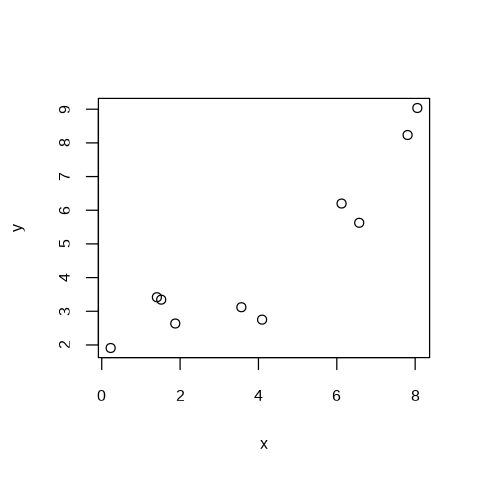

In [2]:
#Data generation
Ndat <- 10
x <- sort(runif(Ndat, 0, 10))
sigTrue <- 1

modMat <- c(0,1)
y <- cbind(1,x) %*% as.matrix(modMat) + rnorm(Ndat, 0, sigTrue)
y <- drop(y)
# columns must be named "x" and "y"
obsdata <- data.frame(cbind(x,y))

options(repr.plot.width = 4, repr.plot.height = 4)
plot(x,y)

thetaTrue <- c(0,0.79,0)

In [3]:
library("rjags")

Warning message:
“package ‘rjags’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [4]:
data <-NULL
data$x<-x
data$y<-y

In [5]:
cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        f[i] <- b0 + b1 * x[i]
        
        y[i] ~ dnorm(f[i],sigma)
 
    } 


    # Priors for  A, B, x0, w

    b0 ~ dunif(-5,5)
    b1 ~ dunif(0,2)
    sigma ~ dunif(0,10)

      
}", file="model_line.bug")
model <- "model_line.bug"

In [14]:
chain_number <- 1
burn_in <-1000
iterations <- 10000
thining <-10

initial <- NULL
initial$b0 <-1 
initial$b1 <- 1
initial$sigma <-1 

In [15]:
jm <- jags.model(model,
                data,
                inits=initial,
                n.chains=chain_number)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10
   Unobserved stochastic nodes: 3
   Total graph size: 48

Initializing model



In [16]:
update(jm,burn_in)

In [17]:
chain<-coda.samples(jm,c("b0","b1","sigma"),n.iter=iterations,thin=thining)

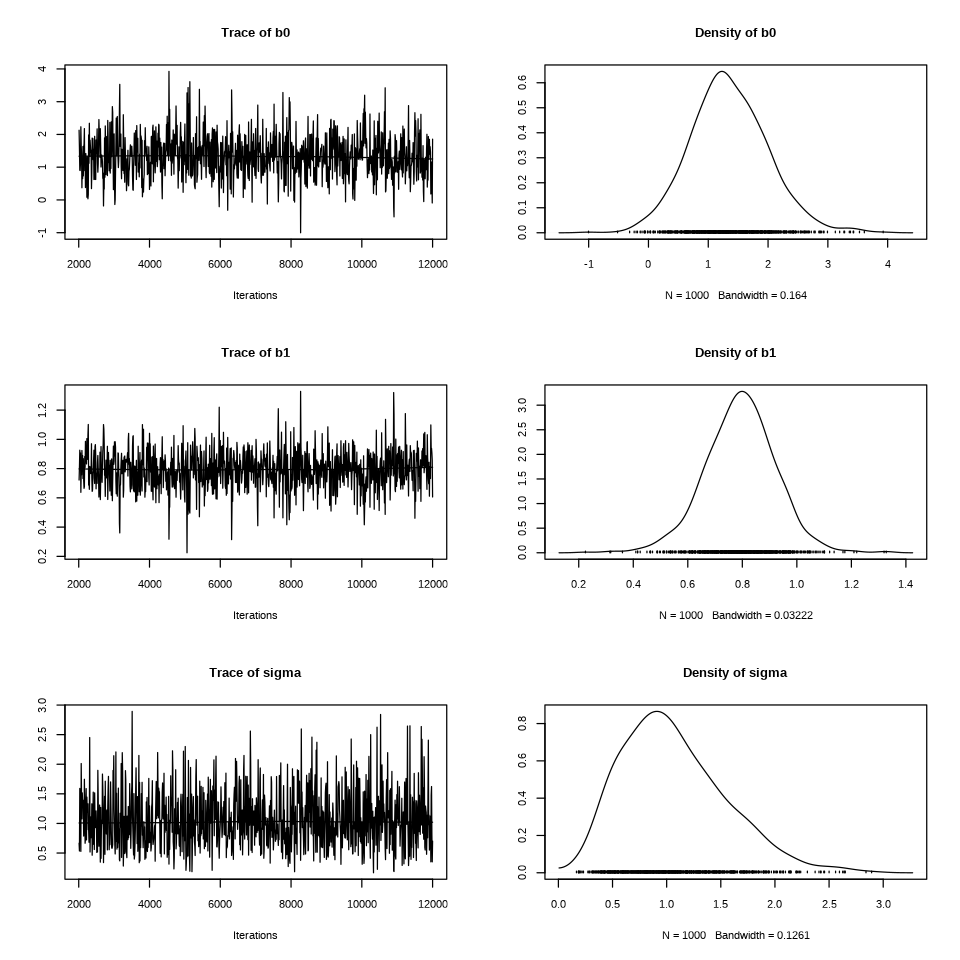

In [18]:
options(repr.plot.width=8,repr.plot.height=8)
plot(chain)

In [19]:
summary(chain)


Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
b0    1.3484 0.6463 0.020438       0.027467
b1    0.7924 0.1304 0.004123       0.004898
sigma 1.0660 0.4778 0.015109       0.016060

2. Quantiles for each variable:

        2.5%    25%    50%    75% 97.5%
b0    0.1563 0.9223 1.3078 1.7478 2.674
b1    0.5233 0.7113 0.7951 0.8734 1.045
sigma 0.3464 0.7211 0.9982 1.3560 2.144


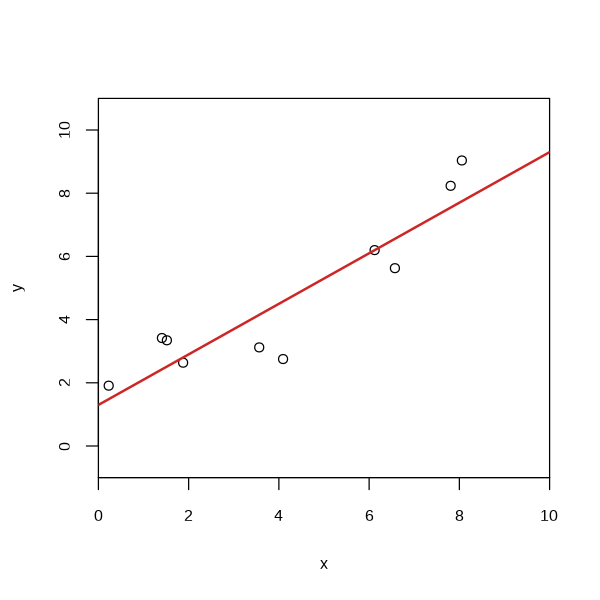

In [13]:
options(repr.plot.width = 5, repr.plot.height = 5)

plotCI(obsdata$x, obsdata$y,
      xlim=c(0,10), ylim=c(-1,11),
      xaxs="i",yaxs="i",
      xlab="x", ylab="y",)

b0 <- 1.30 
b1 <- 0.8 

abline(a = b0, b=b1, lw=2, col='firebrick3')

#### The prior:

- The priors on $\alpha$ and $\text{log}\sigma$ have no parameters.

- the prior on the intercept is driven by the data. A Gaussian distribution is assumed with $\mu=0$ and a standard deviation $\sigma=2$

In [15]:
#parameters:

In [16]:
logprior.linearmodel <- function(theta){
    b0prior      <- dnorm(theta[1], mean=0, sd=2)
    alphaPrior   <- 1
    logysigPrior <- 1
    
    logPrior     <- sum(log10(b0prior),
                        log10(alphaPrior),
                        log10(logysigPrior))
    return(logPrior)
}

#### The likelihood:

$$P(y_j|x_j,\theta,M)=\frac{1}{\sigma\sqrt{2\pi}} \text{exp}\left[-\frac{(y_j-f(x_j;b_0,b_1))^2}{2\sigma~ 2}\right]$$


In [17]:
loglike.linearmodel <- function(theta,obsdata){
    #convert alpha to b_1 and log10(ysig) to ysig
    theta[2] <- tan(theta[2])
    theta[3] <- 10**theta[3]
    
    modPred <- drop(theta[1:2] %*% t(cbind(1,obsdata$x)))
    #Dimensions in mixed vector/matrix products:
    #                    [Ndat] = [P] %*% [P x Ndat]
    logLike <- (1/log(10))*sum(dnorm(modPred - obsdata$y,mean=0,
                                    sd=theta[3], log=TRUE))
    return(logLike)
}

#### The posterior distribution:

$$P(\theta|D) \propto P(D|\theta)\times P(\theta)$$

In [18]:
#Returns c(log10(prior), log10(likelihood)) (each generally unnormalized)
#of the linear model
logpost.linearmodel <- function(theta, obsdata) {
    logprior <- logprior.linearmodel(theta)
    if(is.finite(logprior)){ # only evaluate model if parameters are sensible
        return( c(logprior, loglike.linearmodel(theta, obsdata)))
    } else {
        return(c(-Inf,-Inf))
    }
}

#### Initializing and running the MCMC process:

- the starting values for the Markov Chain are $b_0=2$, $\alpha=\pi/8$ and $\text{log}_{10}(3)$

- the step size for the evolution of the chain are $0.1,\,0.02$ and $0.1$ (respectively for $b_0$, $\alpha$ and $\text{log}\sigma$)

In [19]:
#MC initial values
thetaInit <- c(2,pi/8,log10(3))

#MC step sizes
sampleCov <- diag(c(0.1,0.02,0.1)**2)

In [20]:
source("metropolis.R")

In [21]:
set.seed(150)
allSamp <- metrop(func = logpost.linearmodel,
                  thetaInit = thetaInit,
                  Nburnin = 0,
                  Nsamp =5.e4,
                  sampleCov = sampleCov,
                  verbose=1.e3,
                  obsdata = obsdata)

  1000 of      0 +  50000  0.6210 
  2000 of      0 +  50000  0.6152 
  3000 of      0 +  50000  0.6182 
  4000 of      0 +  50000  0.6230 
  5000 of      0 +  50000  0.6162 
  6000 of      0 +  50000  0.6092 
  7000 of      0 +  50000  0.6119 
  8000 of      0 +  50000  0.6161 
  9000 of      0 +  50000  0.6176 
 10000 of      0 +  50000  0.6168 
 11000 of      0 +  50000  0.6197 
 12000 of      0 +  50000  0.6199 
 13000 of      0 +  50000  0.6182 
 14000 of      0 +  50000  0.6165 
 15000 of      0 +  50000  0.6153 
 16000 of      0 +  50000  0.6149 
 17000 of      0 +  50000  0.6135 
 18000 of      0 +  50000  0.6139 
 19000 of      0 +  50000  0.6134 
 20000 of      0 +  50000  0.6147 
 21000 of      0 +  50000  0.6150 
 22000 of      0 +  50000  0.6159 
 23000 of      0 +  50000  0.6157 
 24000 of      0 +  50000  0.6155 
 25000 of      0 +  50000  0.6150 
 26000 of      0 +  50000  0.6148 
 27000 of      0 +  50000  0.6145 
 28000 of      0 +  50000  0.6140 
 29000 of      0 +  

In [22]:
c.chain1 <- as.mcmc(allSamp[,1])
my.lags =seq(from = 0, to= nrow(allSamp), by=25)
y1 <- autocorr(c.chain1, lags=my.lags)

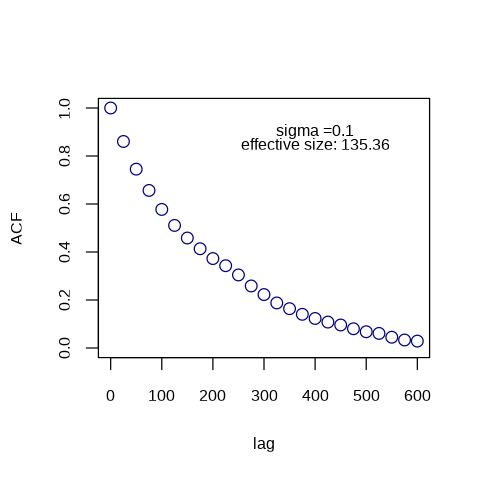

In [23]:
plot(my.lags[1:25], y1[1:25], ylim=c(0,1),
    pch=1, col='navy',
    xlab='lag',ylab='ACF',cex=1.3)
text(400,0.9, paste('sigma =0.1'))
text(400,0.85, sprintf ("effective size: %.2f", effectiveSize(c.chain1)))


In [24]:
# thin by factor 25
thinSel <- seq(from=1, to=nrow(allSamp), by=25) 

postSamp <- allSamp[thinSel,]


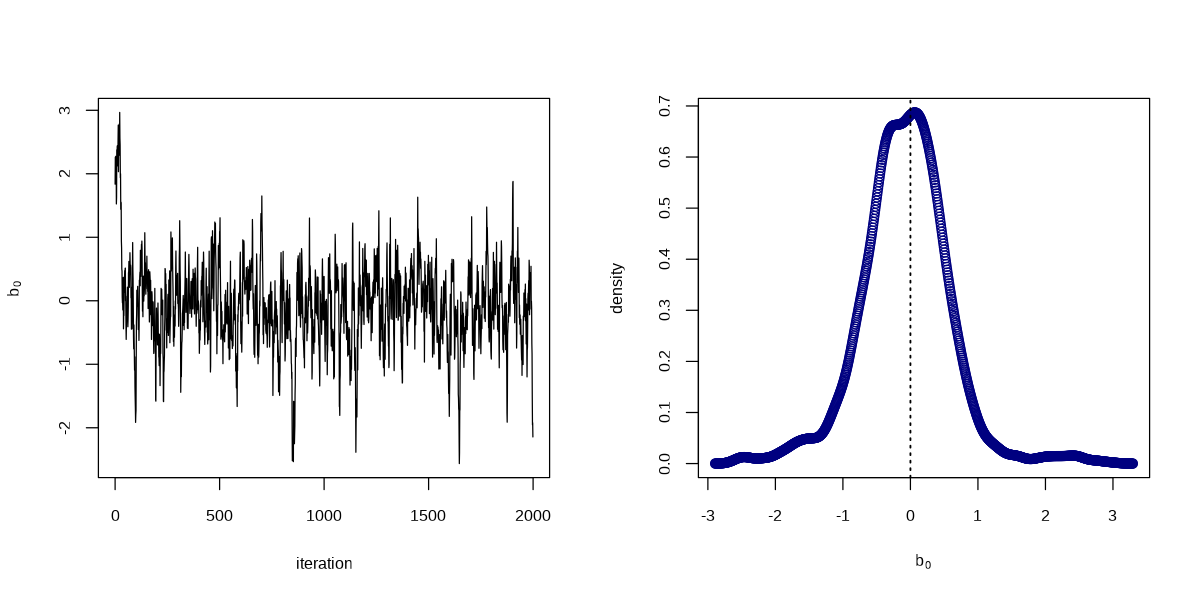

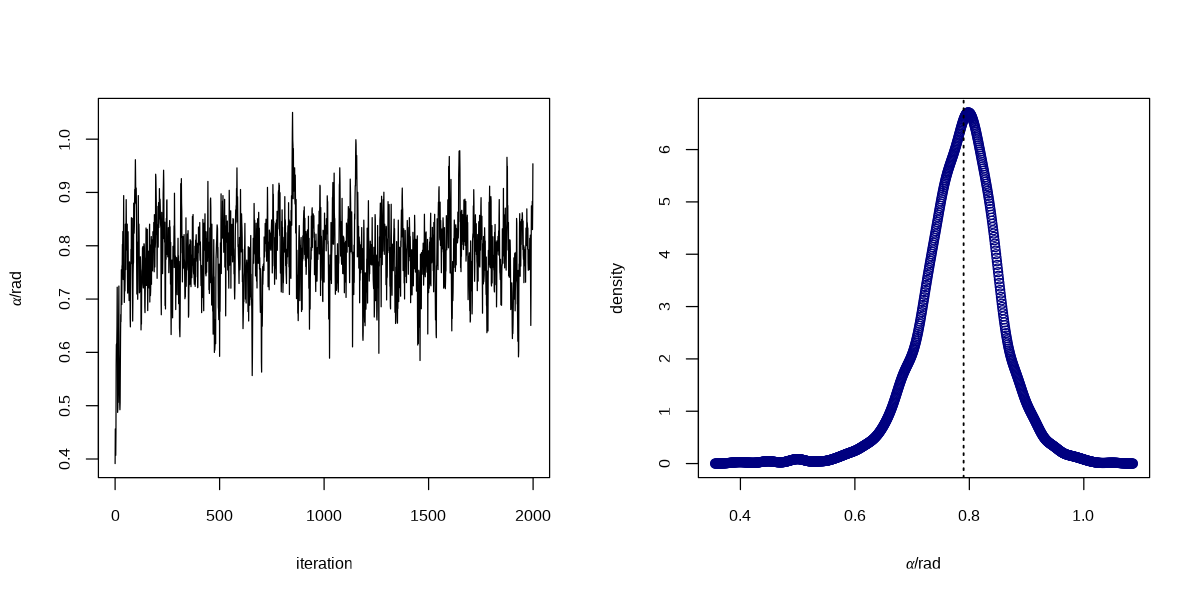

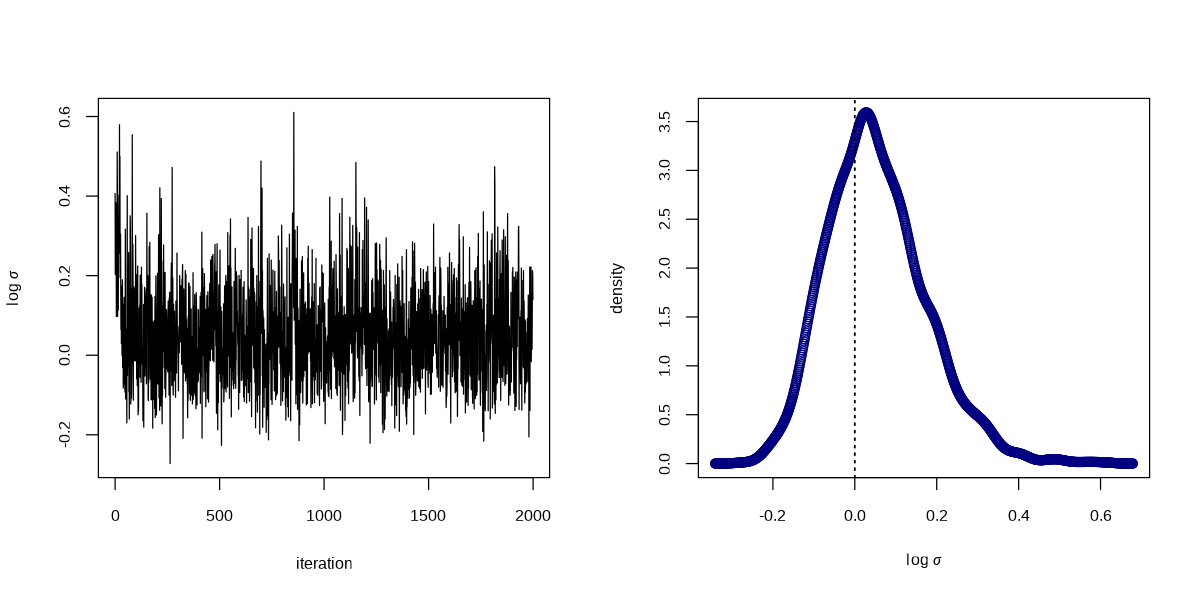

In [25]:
parname <- c(expression(b[0]),
             expression(paste(alpha,"/rad")),
             expression(paste(log," ",sigma)))
nr <- nrow(postSamp)
is <- nr-2000

options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow=c(1,2),mfcol=c(1,2))
for (j in 3:5) {
    
    plot(seq(is,nr-1,1),postSamp[is:nr, j],
        type="l",
        xlab="iteration",
        ylab=parname[j-2])
    
    postDen <- density(postSamp[is:nr,j], n=2**10)

    plot(postDen$x, postDen$y,
        col='navy', lwd = 1,
        xlab=parname[j-2],
        ylab="density")
    
    abline(v=thetaTrue[j-2],
          lwd=1.5,lty=3)
}

#### Posterior parameter estimation:


In [26]:
# The maximum of the sum of the log(Prior) and log(Likelihood)
posMAP   <- which.max(postSamp[,1] + postSamp[,2])
thetaMAP <- postSamp[posMAP, 3:5]
thetaMEAN <- apply(postSamp[,3:5], 2, mean) #Monte Carlo integration
print("Covariance")
cov(postSamp[, 3:5]) #covariance
print("Correlation")
cor(postSamp[, 3:5]) #correlation

print(paste("b_0 =",thetaMEAN[1]))
print(paste(expression(alpha),thetaMEAN[2]))
print(paste(expression(log(sigma)),thetaMEAN[3]))

[1] "Covariance"


0.431300393,-0.0375659372,0.0045242256
-0.037565937,0.0049895817,-0.0006008723
0.004524226,-0.0006008723,0.0143411347


[1] "Correlation"


1.00000000,-0.8097897,0.05752579
-0.80978967,1.0000000,-0.07103270
0.05752579,-0.0710327,1.00000000


[1] "b_0 = -0.0782915528539824"
[1] "alpha 0.78410228273117"
[1] "log(sigma) 0.0531849188583901"


If we want to find the mean of the posterior over the original model parameters $(b_0,b_1,\sigma)$ we MUST transform the individual samples first and then compute the statistics (NOT VICE VERSA)


In [27]:
print(paste("b_1 =", mean(tan(postSamp[,4]))))
print(paste(expression(sigma), mean(10**(postSamp[,5]))))

[1] "b_1 = 1.007170144025"
[1] "sigma 1.17663740541793"


- We get $$(b_0,b_1,\sigma) = (0.17,0.93,1.15)$$


- while the original parameters where $$(b_0,b_1,\sigma) = (0,1,1)$$

Linear fit results:

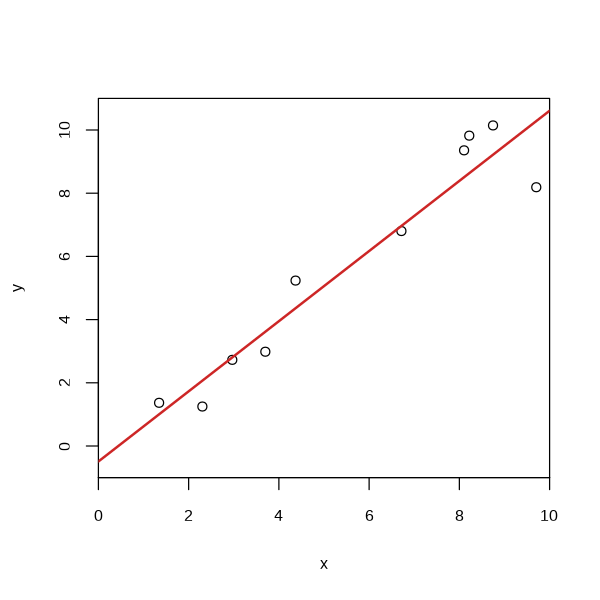

In [22]:
options(repr.plot.width = 5, repr.plot.height = 5)

plotCI(obsdata$x, obsdata$y,
      xlim=c(0,10), ylim=c(-1,11),
      xaxs="i",yaxs="i",
      xlab="x", ylab="y",
      uiw=10**thetaMAP[3],gap=0)

b0 <- thetaMAP[1]
b1 <- tan(thetaMAP[2])

abline(a = b0, b=b1, lw=2, col='firebrick3')

#### Posterior Predictive Distribution

### Fitting a quadratic curve with noise

- we have a set of data we want to fit to a generative model

$$y=f(x) + \epsilon$$

with $$f(x) =b_0+b_1 x + b_2 x^2$$

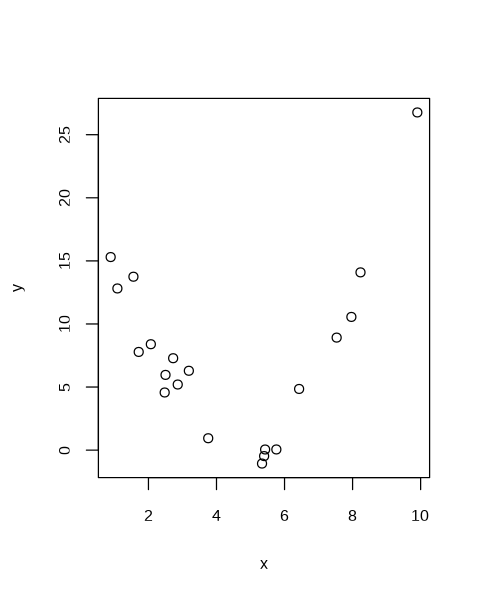

In [2]:
#Data generation
Ndat <- 20
xra  <- c(0,10)
x <-sort(runif(Ndat,min=xra[1],max=xra[2]))
sigTrue <-2

modMat <- c(25, -10, 1)
y <- cbind(1,x,x**2) %*% as.matrix(modMat) + rnorm(Ndat, 0, sigTrue)

y <- drop(y)

# columns must be named "x" and "y"
obsdata <- data.frame(cbind(x,y))

options(repr.plot.width = 4, repr.plot.height = 5)
plot(x,y)

thetaTrue <- c(25,atan(-10),1,log10(2))

#### The prior:

- Gaussian prior for $b_0$, $b_0 \sim N(0,10)$

- $b_1$ is transformed to $\alpha =\text{arctan}b_1$, and a uniform prior is used $\alpha \sim U(0,2\pi)$

- a Gaussian prior is used on $b_2$, $b_2 \sim N(0,5)$

- $\sigma$ is transformed to $\text{log}\sigma$ and an improper uniform prior is used

In [4]:
#
# parameters :
#theta[1] -> b_0
#theta[2] -> alpha
#theta[3] -> b_2
#theta[4] -> log(sigma)

logprior.quadraticmodel <- function(theta) {
    b0Prior    <- dnorm(theta[1], mean=25, sd=10)
    alphaPrior <- 1
    b2Prior    <- dnorm(theta[3], mean=1, sd=5)
    logysigPrior <- 1
    
    logPrior <- sum(log10(b0Prior), log10(alphaPrior),
                    log10(b2Prior), log10(logysigPrior))
    return(logPrior)
}

#### The likelihood:

$$P(y_j|x_j,\theta,M)=\frac{1}{\sigma\sqrt{2\pi}} \text{exp}\left[-\frac{(y_j-f(x_j;b_0,b_1,b_2))^2}{2\sigma^ 2}\right]$$


In [5]:
#
# parameters :
#theta[1] -> b_0
#theta[2] -> alpha
#theta[3] -> b_2
#theta[4] -> log(sigma)

loglike.quadraticmodel <- function(theta,obsdata){
    #convert alpha to b_1 and log10(ysig) to ysig, b_0 and b_2 remain the same
    theta[2] <- tan(theta[2])
    theta[4] <- 10**theta[4]
    
    modPred <- drop(theta[1:3] %*% t(cbind(1,obsdata$x,(obsdata$x)**2)))
    #Dimensions in mixed vector/matrix products:
    #                    [Ndat] = [P] %*% [P x Ndat]
    logLike <- (1/log(10))*sum(dnorm(modPred - obsdata$y,mean=0,
                                    sd=theta[4], log=TRUE))
    return(logLike)
}

#### The posterior


$$P(\theta|D) \propto P(D|\theta)\times P(\theta)$$

In [6]:
#Returns c(log10(prior), log10(likelihood)) (each generally unnormalized)
#of the linear model
logpost.quadraticmodel <- function(theta, obsdata) {
    logprior <- logprior.quadraticmodel(theta)
    if(is.finite(logprior)){ # only evaluate model if parameters are sensible
        return( c(logprior, loglike.quadraticmodel(theta, obsdata)))
    } else {
        return(c(-Inf,-Inf))
    }
}

#### Initializing and running the MCMC process:

- the starting values for the Markov Chain are $b_0=2$, $\alpha=\pi/8$ and $\text{log}_{10}(3)$

- the step size for the evolution of the chain are $0.1,\,0.02$ and $0.1$ (respectively for $b_0$, $\alpha$ and $\text{log}\sigma$)

In [7]:
#MC initial values
thetaInit <- c(27.4, atan(-11.7), 1.18, log10(2.4))

#MC step sizes
sampleCov <- diag(c(0.1,0.01,0.01,0.01)**2)


In [8]:
source("metropolis.R")

In [9]:
set.seed(250)
allSamp <- metrop(func = logpost.quadraticmodel,
                  thetaInit = thetaInit,
                  Nburnin = 2.e4,
                  Nsamp =2.e5,
                  sampleCov = sampleCov,
                  verbose=2.e3,
                  obsdata = obsdata)


  2000 of  20000 +  2e+05  0.1180 
  4000 of  20000 +  2e+05  0.1105 
  6000 of  20000 +  2e+05  0.0991 
  8000 of  20000 +  2e+05  0.0975 
 10000 of  20000 +  2e+05  0.0963 
 12000 of  20000 +  2e+05  0.0902 
 14000 of  20000 +  2e+05  0.0849 
 16000 of  20000 +  2e+05  0.0845 
 18000 of  20000 +  2e+05  0.0866 
 20000 of  20000 +  2e+05  0.0873 
 22000 of  20000 +  2e+05  0.0868 
 24000 of  20000 +  2e+05  0.0869 
 26000 of  20000 +  2e+05  0.0876 
 28000 of  20000 +  2e+05  0.0873 
 30000 of  20000 +  2e+05  0.0854 
 32000 of  20000 +  2e+05  0.0835 
 34000 of  20000 +  2e+05  0.0827 
 36000 of  20000 +  2e+05  0.0839 
 38000 of  20000 +  2e+05  0.0859 
 40000 of  20000 +  2e+05  0.0867 
 42000 of  20000 +  2e+05  0.0871 
 44000 of  20000 +  2e+05  0.0881 
 46000 of  20000 +  2e+05  0.0898 
 48000 of  20000 +  2e+05  0.0896 
 50000 of  20000 +  2e+05  0.0903 
 52000 of  20000 +  2e+05  0.0917 
 54000 of  20000 +  2e+05  0.0936 
 56000 of  20000 +  2e+05  0.0948 
 58000 of  20000 +  

In [36]:
# thin by factor 100
thinSel <- seq(from=1, to=nrow(allSamp), by=25) 

postSamp <- allSamp[thinSel,]


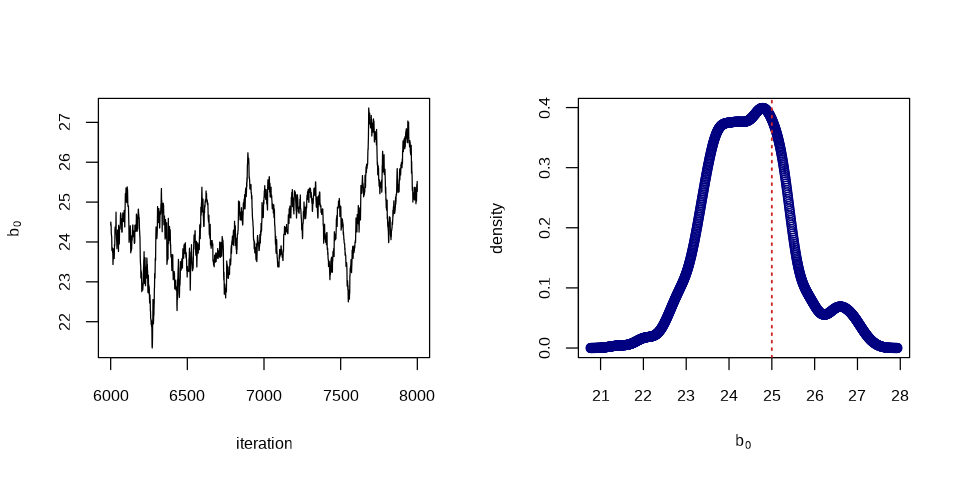

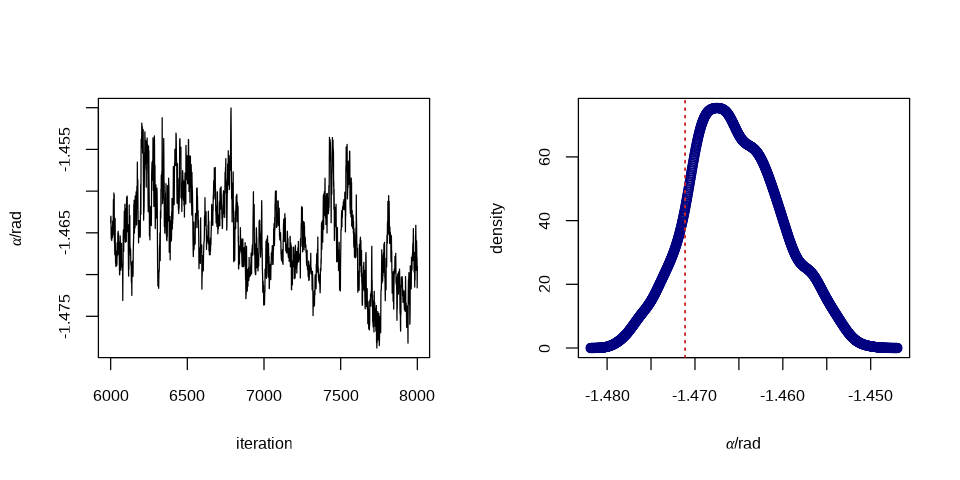

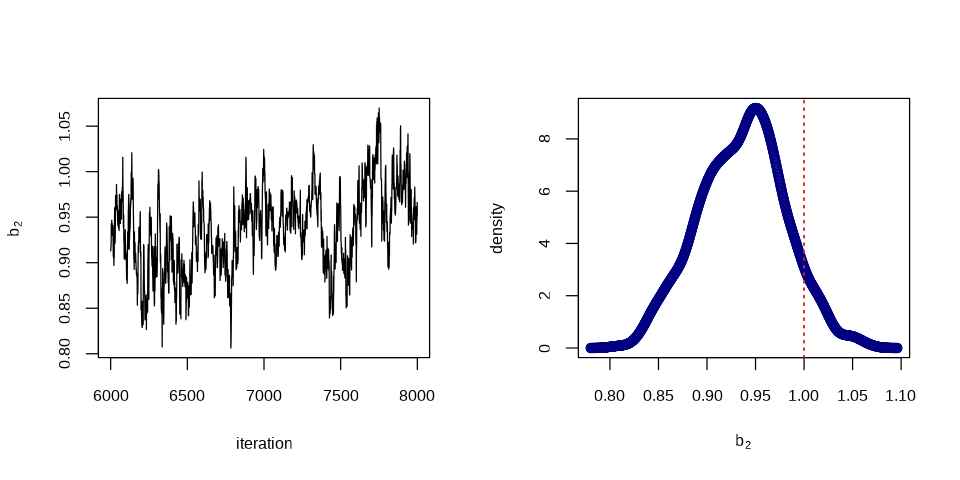

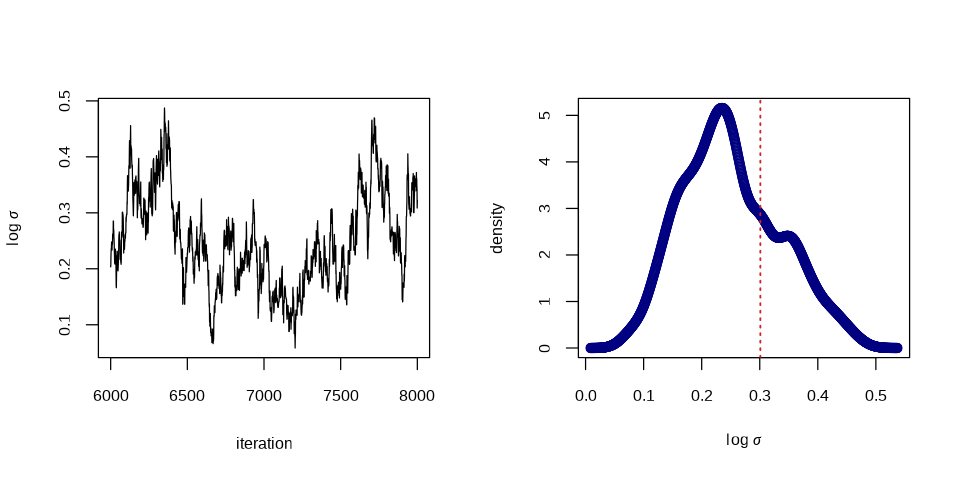

In [37]:
parname <- c(expression(b[0]),
             expression(paste(alpha,"/rad")),
             expression(b[2]),
             expression(paste(log," ",sigma)))
nr <- nrow(postSamp)
is <- nr-2000

options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow=c(1,2),mfcol=c(1,2))
for (j in 3:6) {
    
    plot(seq(is,nr,1),postSamp[is:nr, j],
        type="l",
        xlab="iteration",
        ylab=parname[j-2])
    
    postDen <- density(postSamp[is:nr,j], n=2**10)

    plot(postDen$x, postDen$y,
        col='navy', lwd = 1,
        xlab=parname[j-2],
        ylab="density")
    
    abline(v=thetaTrue[j-2],
          lwd=1.5,lty=3,col='firebrick3')
}

#### Posterior parameter estimation:


In [38]:
# The maximum of the sum of the log(Prior) and log(Likelihood)
posMAP   <- which.max(postSamp[,1] + postSamp[,2])
thetaMAP <- postSamp[posMAP, 3:6]
thetaMEAN <- apply(postSamp[,3:6], 2, mean) #Monte Carlo integration
print("Covariance")
cov(postSamp[, 3:6]) #covariance
print("Correlation")
cor(postSamp[, 3:6]) #correlation

print(paste("b_0 =",thetaMEAN[1]))
print(paste(expression(alpha),thetaMEAN[2]))
print(paste("b_2 =",thetaMEAN[3]))
print(paste(expression(log(sigma)),thetaMEAN[4]))

[1] "Covariance"


1.469134005,-6.408136e-03,0.0456910982,4.554174e-03
-0.006408136,3.850921e-05,-0.0003031103,-2.715567e-06
0.045691098,-3.031103e-04,0.0025454543,1.077528e-04
0.004554174,-2.715567e-06,0.0001077528,6.185787e-03


[1] "Correlation"


1.00000000,-0.851959027,0.74716796,0.047772880
-0.85195903,1.000000000,-0.96813476,-0.005563919
0.74716796,-0.968134762,1.00000000,0.027154918
0.04777288,-0.005563919,0.02715492,1.000000000


[1] "b_0 = 24.3804106589361"
[1] "alpha -1.46488242759929"
[1] "b_2 = 0.932648708463877"
[1] "log(sigma) 0.262279158212064"


- We get $$(b_0,b_1,b_2,\sigma) = (24,-9.88,1.55)$$


- while the original parameters where $$(b_0,b_1,b_2,\sigma) = (25,-10,1,2)$$

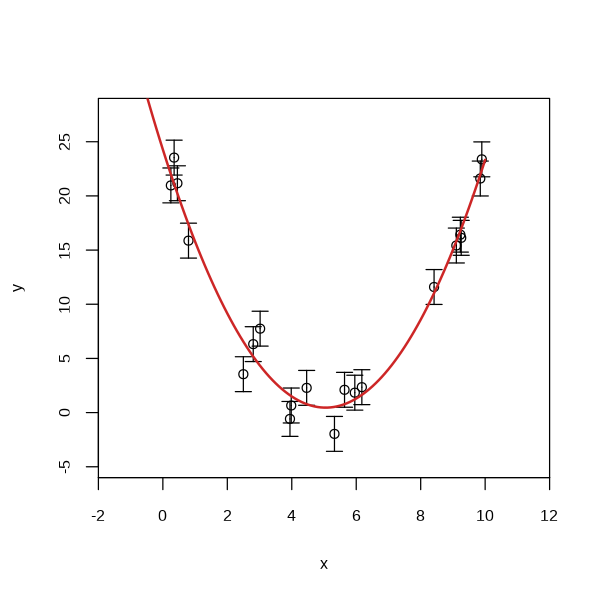

In [39]:
options(repr.plot.width = 5, repr.plot.height = 5)

plotCI(obsdata$x, obsdata$y,
      xlim=c(-2,12), ylim=c(-6,29),
      xaxs="i",yaxs="i",
      xlab="x", ylab="y",
      uiw=10**thetaMAP[4],gap=0)

b0 <- thetaMAP[1]
b1 <- tan(thetaMAP[2])
b2 <- thetaMAP[3]

xsamp <- seq(-10,10,0.1)
ysamp <- cbind(1,
              xsamp,
              xsamp**2) %*% as.matrix(c(b0,
                                       b1,
                                       b2))

lines(xsamp, drop(ysamp), lwd=2, col='firebrick3')

In [40]:
logpost.quadraticmodel(thetaInit,obsdata)

[1]  -4.139499 -22.076746